<a target="_blank" href="https://colab.research.google.com/github/nz-gravity/LogPSplinePSD/tree/main/docs/studies/lvk/lvk_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

 # LVK Demo




In [11]:
! pip install logPsplinePSD[gw] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

ModuleNotFoundError: No module named 'imp'

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2163718413.py:14: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(URL, comment="#", sep="\s+", header=None)
/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.0, so it will not be used.
  warnings.warn(


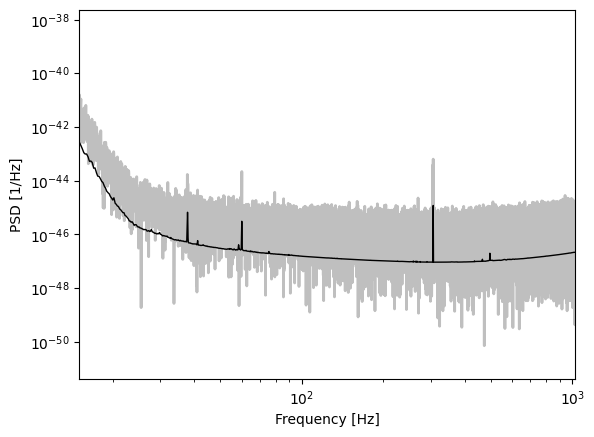

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from log_psplines.datatypes import Periodogram, Timeseries

FMIN, FMAX = 15, 1024


URL = "https://raw.githubusercontent.com/bilby-dev/bilby/main/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt"


def load_lvk_psd() -> Periodogram:
    df = pd.read_csv(URL, comment="#", sep="\s+", header=None)
    freq, asd = df[0].values, df[1].values
    return Periodogram(freq, asd**2)


def create_white_noise(sampling_frequency: float, duration: float):
    number_of_samples = duration * sampling_frequency
    number_of_samples = int(np.round(number_of_samples))

    number_of_samples = int(np.round(duration * sampling_frequency))
    number_of_frequencies = int(np.round(number_of_samples / 2) + 1)

    frequencies = np.linspace(
        start=0, stop=sampling_frequency / 2, num=number_of_frequencies
    )
    norm1 = 0.5 * duration**0.5
    re1, im1 = np.random.normal(0, norm1, (2, len(frequencies)))
    white_noise = re1 + 1j * im1

    # set DC and Nyquist = 0
    white_noise[0] = 0
    # no Nyquist frequency when N=odd
    if np.mod(number_of_samples, 2) == 0:
        white_noise[-1] = 0

    # python: transpose for use with infft
    white_noise = np.transpose(white_noise)
    frequencies = np.transpose(frequencies)
    return white_noise, frequencies


def get_lvk_noise_realisation(sampling_frequency=4096.0, duration=32.0):
    psd = load_lvk_psd()
    white_noise, frequencies = create_white_noise(sampling_frequency, duration)

    with np.errstate(invalid="ignore"):
        colored_noise = (
            np.interp(frequencies, psd.freqs, psd.power) ** 0.5 * white_noise
        )

    n_samples = int(sampling_frequency * duration)
    colored_noise_time = np.fft.irfft(colored_noise, n=n_samples)
    times = np.arange(n_samples) / sampling_frequency
    ts = Timeseries(times, colored_noise_time)

    # Compute periodogram from the time series
    freqs = np.fft.rfftfreq(n_samples, 1 / sampling_frequency)
    fft_data = np.fft.rfft(colored_noise_time)
    pdgrm_power = np.abs(fft_data) ** 2
    pdgrm = Periodogram(freqs[1:-1], pdgrm_power[1:-1])
    return ts, pdgrm


lvk_psd = load_lvk_psd()
lvk_noise, lvk_pdgrm = get_lvk_noise_realisation()


plt.plot(
    lvk_pdgrm.freqs,
    (lvk_pdgrm.power),
    label="LVK noise realisation",
    color="gray",
    alpha=0.5,
    lw=2,
)
plt.loglog(lvk_psd.freqs, lvk_psd.power, "k-", label="aLIGO O4 design", lw=1)
plt.xlim(FMIN, FMAX)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [1/Hz]");

## Knot allocation

In [9]:
# knot allocation

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d


def extract_peaks(vec, window=9, threshold_factor=1.0):
    """
    vec: array-like, the periodogram in original scale
    returns: array with log-peaks, otherwise 0
    """
    vec = np.asarray(vec)
    n = len(vec)

    # Rolling median (window size 9, centered)
    med_psd = (
        pd.Series(vec)
        .rolling(window=window, center=True, min_periods=1)
        .median()
        .to_numpy()
    )

    # Power ratio
    ratio_med = vec / (med_psd + np.finfo(float).eps)
    log_ratio_med = np.log(ratio_med)

    # Replace NaNs with mean
    mean_lr = np.nanmean(log_ratio_med)
    log_ratio_med = np.where(np.isnan(log_ratio_med), mean_lr, log_ratio_med)

    # Threshold = Q3 + 1.5 * (Q3 - Q1)
    Q1 = np.nanquantile(log_ratio_med, 0.25)
    Q3 = np.nanquantile(log_ratio_med, 0.75)
    threshold = (Q3 + 1.5 * (Q3 - Q1)) * threshold_factor

    # Find values greater than threshold
    out = np.zeros(n)
    out[log_ratio_med > threshold] = log_ratio_med[log_ratio_med > threshold]

    return out


from scipy.signal.windows import gaussian


def smooth_peaks(vec, d):
    """
    Returns the smoothed vector with peaks.

    Parameters
    ----------
    vec : array-like, Vector with peaks.
    d : int, Propagation distance to the left and right.
    """
    vec = np.asarray(vec)
    out = vec.copy()
    n = len(vec)

    # Gaussian decay (like gsignal::gausswin in R)
    gauss_win = gaussian(2 * d, std=2.5)
    dec = gauss_win[:d][::-1]  # take first d and reverse

    for i in range(1, d + 1):
        # propagate to the left
        aux1 = np.concatenate([vec[i:], np.zeros(i)])
        # propagate to the right
        aux2 = np.concatenate([np.zeros(i), vec[: n - i]])

        # apply Gaussian decay
        aux1 = aux1 * dec[i - 1]
        aux2 = aux2 * dec[i - 1]

        # update with maximum
        out = np.maximum(out, aux1)
        out = np.maximum(out, aux2)

    # Areas between peaks: aassign
    m0 = np.sum(out) * 0.05  # 5 percent of total peaks
    n0 = np.count_nonzero(out)  # number of non-zeros
    if n0 > 0:
        min_value = m0 / n0
        out[out <= min_value] = min_value

    return out


def knotLoc(vec, k, degree, eqSpaced=False):
    """
    Compute knot locations for B-spline densities.

    Parameters
    ----------
    vec : array-like, Numeric vector containing the smoothed peaks.
    k : int,  Number of B-spline densities.
    degree : int
        Degree of the B-spline densities.
    eqSpaced : bool, optional (default=False)
        If True, returns equidistant knots in [0,1].

    Returns
    -------
    knots : ndarray
        Knot positions in [0,1].
    """
    K = k - degree + 1  # number of internal knots in [0,1]
    vec = np.asarray(vec)

    if eqSpaced:
        knots = np.linspace(0, 1, K)
        return knots

    N = len(vec)

    # Normalized density
    dens = vec / np.sum(vec)
    cumf = np.cumsum(dens)

    # Distribution function (maps [0,1] -> [0,1])
    df = interp1d(
        np.linspace(0, 1, N),
        cumf,
        kind="linear",
        bounds_error=False,
        fill_value=(0, 1),
    )

    # Inverse distribution function
    grid = np.linspace(0, 1, N)
    dfvec = df(grid)
    invDf = interp1d(
        dfvec, grid, kind="linear", bounds_error=False, fill_value=np.nan
    )

    # Internal points (exclude 0 and 1)
    v = np.linspace(0, 1, K)
    v = v[1:-1]

    knots = np.concatenate(([0], invDf(v), [1]))

    return knots


def peak_and_knot_loc(pdgrm):
    # 1. Identifying peaks
    aux = extract_peaks(pdgrm.power, window=9, threshold_factor=1.0)

    # 2. Smoothed peaks
    r = smooth_peaks(aux, 40)

    # 3. Compute knots
    k = knotLoc(vec=r, k=100, degree=3)
    maxFreq = np.max(pdgrm.freqs)  # Maximum frequency
    return r, k * maxFreq

In [10]:
lvk_std = np.std(lvk_noise.y)
noise_standardised = (lvk_noise.y - np.mean(lvk_noise.y)) / lvk_std
freqs = np.fft.rfftfreq(lvk_noise.n, 1 / lvk_noise.fs)
pdgrm = Periodogram(
    freqs=freqs, power=np.abs(np.fft.rfft(noise_standardised)) ** 2
)
pdgrm = pdgrm.cut(FMIN, FMAX)
plt.loglog(pdgrm.freqs, pdgrm.power, color="gray", alpha=0.5)

NameError: name 'lvk_noise' is not defined

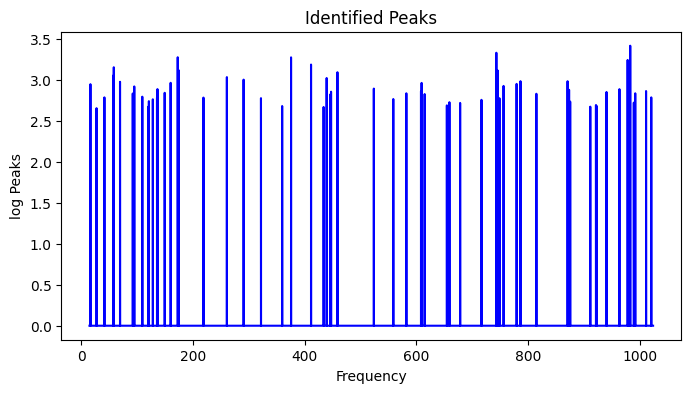

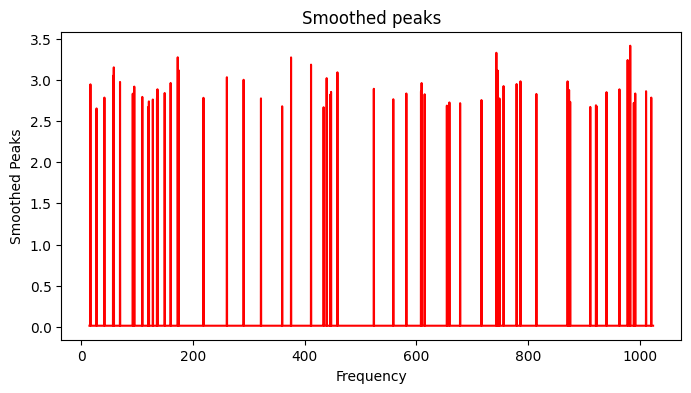

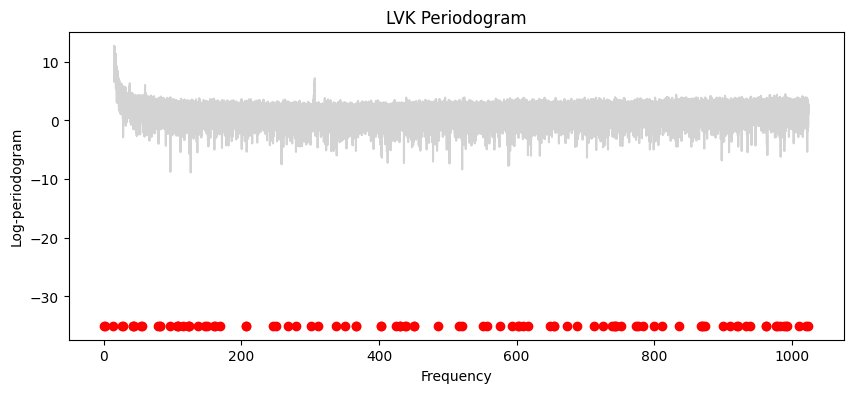

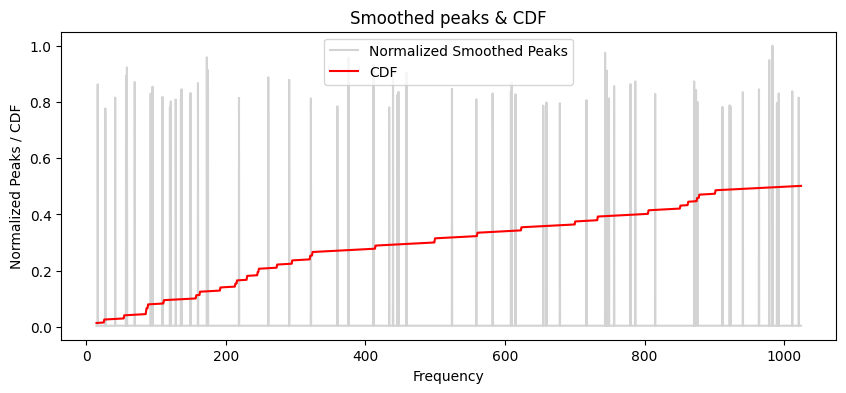

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 1. Identifying peaks
aux = extract_peaks(pdgrm.power, window=9, threshold_factor=1.0)

# 2. Smoothed peaks
r = smooth_peaks(aux, 40)

# 3. Plot identified peaks
plt.figure(figsize=(8, 4))
plt.plot(pdgrm.freqs, aux, linestyle="-", color="blue")
plt.title("Identified Peaks")
plt.xlabel("Frequency")
plt.ylabel("log Peaks")
plt.show()

# 4. Plot areas to allocate knots (smoothed peaks)
plt.figure(figsize=(8, 4))
plt.plot(pdgrm.freqs, r, linestyle="-", color="red")
plt.title("Smoothed peaks")
plt.xlabel("Frequency")
plt.ylabel("Smoothed Peaks")
plt.show()

#####################
### Ploting Knots ###
#####################

# 1. Compute knots
k = knotLoc(vec=r, k=100, degree=3)
maxFreq = np.max(pdgrm.freqs)  # Maximum frequency

# 2. Plot LVK periodogram
plt.figure(figsize=(10, 4))
plt.plot(pdgrm.freqs, np.log(pdgrm.power), linestyle="-", color="lightgray")
plt.title("LVK Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Log-periodogram")

# Red points: knot locations
plt.scatter(k * maxFreq, np.full_like(k, -35), color="red", label="Knots")

# 3. Distribution function from smoothed peaks
N = len(r)
dens = r / np.sum(r)
cumf = np.cumsum(dens)

# Interpolation function (distribution function)
df = interp1d(
    np.linspace(0, 1, N),
    cumf,
    kind="linear",
    bounds_error=False,
    fill_value=(0, 1),
)

# 4. Plot areas to allocate knots
plt.figure(figsize=(10, 4))
plt.plot(
    pdgrm.freqs,
    r / np.max(r),
    linestyle="-",
    color="lightgray",
    label="Normalized Smoothed Peaks",
)

# Add cumulative distribution (red line)
plt.plot(
    pdgrm.freqs,
    df(np.array(pdgrm.freqs) / 2048),
    color="red",
    label="CDF",
)

plt.title("Smoothed peaks & CDF")
plt.xlabel("Frequency")
plt.ylabel("Normalized Peaks / CDF")
plt.legend()
plt.show()

In [ ]:
from log_psplines.mcmc import run_mcmc

# Run MCMC
mcmc_results = run_mcmc(
    pdgrm,
    n_warmup=1000,
    n_samples=2000,
    knot_kwargs=dict(knots=k * maxFreq, degree=3),
    verbose=True,
)

In [ ]:
from log_psplines.plotting import plot_pdgrm
from IPython.display import display, HTML

fig = plot_pdgrm(idata=mcmc_results, interactive=True)

display(HTML(fig.to_html(include_plotlyjs="cdn")))

In [ ]:
# This is the current saved LVK knot allocation method in logPsplinePSD
mcmc_results_v2 = run_mcmc(
    pdgrm,
    n_warmup=1000,
    n_samples=2000,
    knot_kwargs=dict(degree=3, method="lvk"),
    verbose=True,
)

In [ ]:
from log_psplines.plotting import plot_pdgrm
from IPython.display import display, HTML

fig = plot_pdgrm(idata=mcmc_results_v2, interactive=True)
display(HTML(fig.to_html(include_plotlyjs="cdn")))

## GW1500914



In [ ]:
from log_psplines.example_datasets.lvk_data import LVKData

data = LVKData.from_event("GW150914")
data.plot_psd()
pdgrm = Periodogram(data.freqs, data.psd)
pdgrm = pdgrm.cut(20, 1000)

In [ ]:
r, k = peak_and_knot_loc(pdgrm)
gw150914_psd_patricio = run_mcmc(
    pdgrm,
    n_warmup=1000,
    n_samples=2000,
    knot_kwargs=dict(degree=3, knots=k),
    verbose=True,
    sampler="mh",
)

In [ ]:
fig = plot_pdgrm(idata=gw150914_psd_patricio, interactive=True)
display(HTML(fig.to_html(include_plotlyjs="cdn")))

In [ ]:
gw150914_psd = run_mcmc(
    pdgrm,
    n_warmup=1000,
    n_samples=2000,
    knot_kwargs=dict(degree=3, method="lvk"),
    verbose=True,
    sampler="mh",
)

In [ ]:
fig = plot_pdgrm(idata=gw150914_psd, interactive=True)
display(HTML(fig.to_html(include_plotlyjs="cdn")))

In [14]:
#########################################
### NEW KNOT ALLOCATION SCHEME - TEST ###
#########################################

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
#from scipy.signal.windows import gaussian
from scipy.stats import beta

def extract_peaks(vec):
    """
    vec: array-like, the periodogram in original scale
    returns: array with log-peaks, otherwise 0
    """
    vec = np.asarray(vec)
    n   = len(vec)

    # Rolling median (window size 9, centered)
    med_psd = pd.Series(vec).rolling(window=9, center=True, min_periods=1).median().to_numpy()

    # Power ratio
    ratio_med = vec / (med_psd + np.finfo(float).eps)
    log_ratio_med = np.log(ratio_med)

    # Replace NaNs with mean
    mean_lr = np.nanmean(log_ratio_med)
    log_ratio_med = np.where(np.isnan(log_ratio_med), mean_lr, log_ratio_med)

    # Threshold = Q3 + 1.5 * (Q3 - Q1)
    Q1 = np.nanquantile(log_ratio_med, 0.25)
    Q3 = np.nanquantile(log_ratio_med, 0.75)
    threshold = Q3 + 1.5 * (Q3 - Q1)

    # Find values greater than threshold
    out = np.zeros(n)
    out[log_ratio_med > threshold] = log_ratio_med[log_ratio_med > threshold]

    return out

def smooth_peaks(vec, d):
    """
    Returns the smoothed vector with peaks.

    Parameters
    ----------
    vec : array-like, Vector with peaks.
    d : int, Propagation distance to the left and right.
    """
    vec = np.asarray(vec)
    out = vec.copy()
    n = len(vec)

    # Gaussian decay (like gsignal::gausswin in R)
    # gauss_win = gaussian(2 * d, std=2.5)
    # dec = gauss_win[:d][::-1]  # take first d and reverse

    # Beta decay
    dec = beta.cdf(np.linspace(0, 1, d+2)[1:-1], a=2, b=0.5)[::-1]  # Reverse

    for i in range(1, d + 1):
        # propagate to the left
        aux1 = np.concatenate([vec[i:], np.zeros(i)])
        # propagate to the right
        aux2 = np.concatenate([np.zeros(i), vec[:n - i]])

        # apply Gaussian decay
        aux1 = aux1 * dec[i - 1]
        aux2 = aux2 * dec[i - 1]

        # update with maximum
        out = np.maximum(out, aux1)
        out = np.maximum(out, aux2)

    # Areas between peaks: aassign
    m0 = np.sum(out) * 0.05     # 5 percent of total peaks
    n0 = np.count_nonzero(out)  # number of non-zeros
    if n0 > 0:
        min_value = m0 / n0
        out[out <= min_value] = min_value

    return out

def knotLoc(vec, k, degree, freq=None, eqSpaced=False):
    """
    vec    : numeric array containing the smoothed peaks
    k      : number of B-spline densities
    degree : positive integer specifying the degree of the B-spline densities
    freq   : optional array of corresponding frequencies
    eqSpaced : if True, returns equidistant knots
    """

    K = k - degree + 1  # number of internal knots [0,1]

    if eqSpaced:
        knots = np.linspace(0, 1, K)  # Equidistant knots
        return knots

    N = len(vec)
    dens = vec / np.sum(vec)
    cumf = np.cumsum(dens)

    if freq is None:
        freq1 = 0
        freqN = 1
    else:
        freq1 = freq[0]
        freqN = freq[-1]

    freq = np.linspace(freq1, freqN, N)

    # Distribution function
    df = interp1d(freq, cumf, bounds_error=False, fill_value=(0,1))

    # Inverse distribution function
    dfvec = df(freq)
    invDf = interp1d(dfvec, freq, bounds_error=False, fill_value="extrapolate")

    v = np.linspace(0, 1, K)
    v = v[1:-1]  # remove first and last

    knots = np.concatenate(([freq1], invDf(v), [freqN]))

    return knots

def grid(g, k):
    """
    Matches the knots (k) to the closest values in the grid (g)
    and returns a unique set of knots.

    g : array-like, grid of values
    k : array-like, knots
    """
    g = np.array(g)
    k = np.array(k)

    # Find the closest value in g for each knot
    out = np.array([g[np.argmin(np.abs(g - v))] for v in k])

    # Keep only unique values
    out = np.unique(out)

    return out

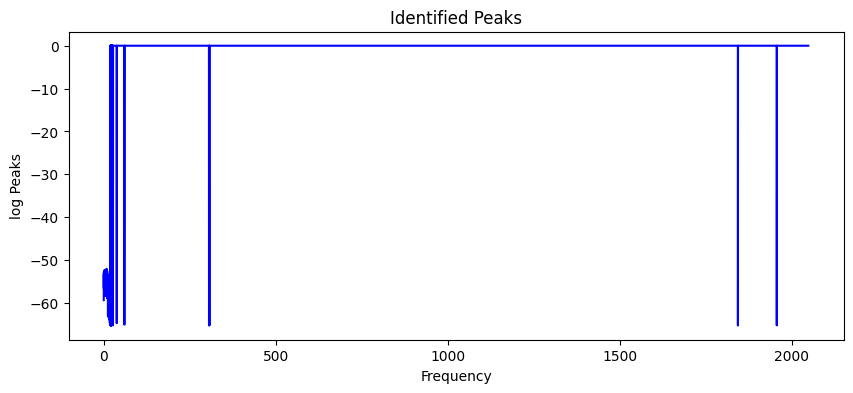

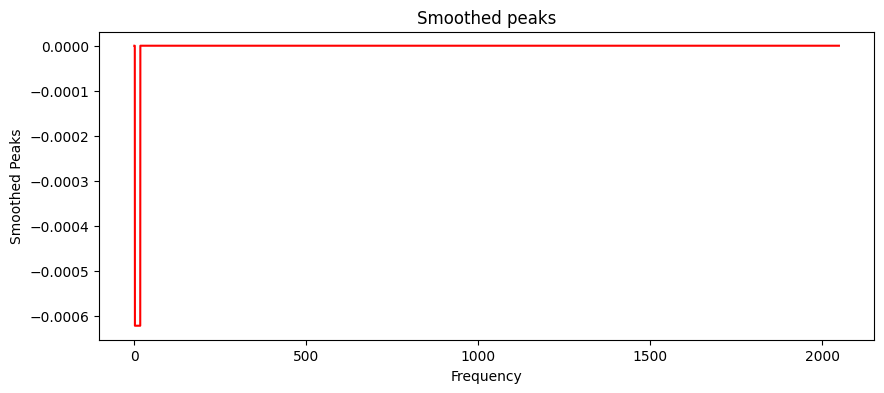

/tmp/ipython-input-1676220489.py:63: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs, r / np.max(r), linestyle='-', color='lightgray', label="Normalized Smoothed Peaks")
/tmp/ipython-input-1676220489.py:63: RuntimeWarning: invalid value encountered in divide
  plt.plot(freqs, r / np.max(r), linestyle='-', color='lightgray', label="Normalized Smoothed Peaks")


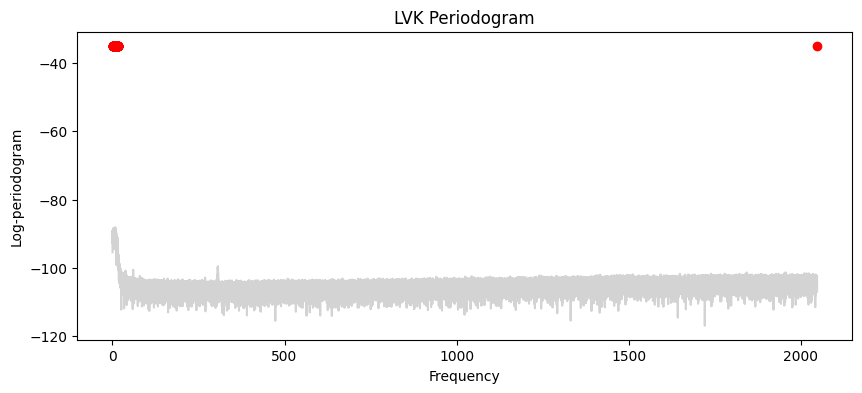

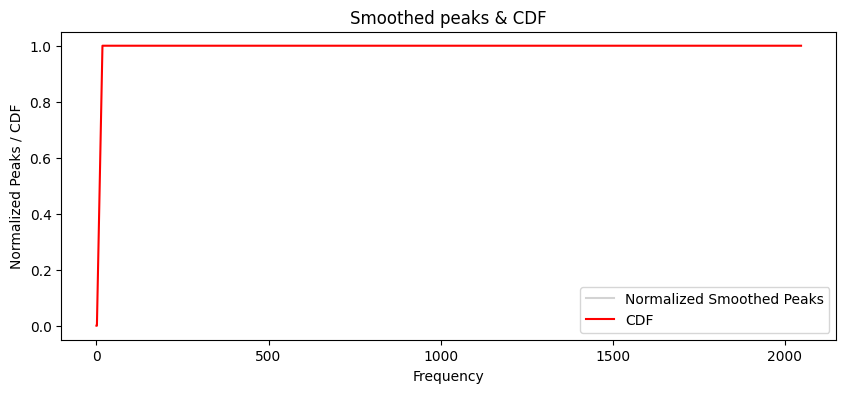

In [16]:
### TESTING THE CODE ###

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

freqs = lvk_pdgrm.freqs
pdgrm = lvk_pdgrm.power

#freqs = pdgrm.freqs
#pdgrm = pdgrm.power

# 1. Identifying peaks
aux = extract_peaks(pdgrm)

# 2. Smoothed peaks
r = smooth_peaks(aux, 40)

# 3. Plot identified peaks
plt.figure(figsize=(10, 4))
plt.plot(freqs, aux, linestyle='-', color='blue')
plt.title("Identified Peaks")
plt.xlabel("Frequency")
plt.ylabel("log Peaks")
plt.show()

# 4. Plot areas to allocate knots (smoothed peaks)
plt.figure(figsize=(10, 4))
plt.plot(freqs, r, linestyle='-', color='red')
plt.title("Smoothed peaks")
plt.xlabel("Frequency")
plt.ylabel("Smoothed Peaks")
plt.show()

#####################
### Ploting Knots ###
#####################

# 1. Compute knots
k = knotLoc(vec=r, k=100, freq = freqs, degree=3)
k = grid(freqs, k)
maxFreq = np.max(freqs)  # Maximum frequency

# 2. Plot LVK periodogram
plt.figure(figsize=(10, 4))
plt.plot(freqs, np.log(pdgrm), linestyle='-', color='lightgray')
plt.title("LVK Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Log-periodogram")

# Red points: knot locations
plt.scatter(k, np.full_like(k, -35), color='red', label="Knots")

# 3. Distribution function from smoothed peaks
N    = len(r)
dens = r / np.sum(r)
cumf = np.cumsum(dens)

# Interpolation function (distribution function)
df = interp1d(np.linspace(0, 1, N), cumf, kind='linear', bounds_error=False, fill_value=(0,1))

# 4. Plot areas to allocate knots
plt.figure(figsize=(10, 4))
plt.plot(freqs, r / np.max(r), linestyle='-', color='lightgray', label="Normalized Smoothed Peaks")

# Add cumulative distribution (red line)
plt.plot(freqs, df(np.array(freqs) / 2048), color='red', label="CDF")

plt.title("Smoothed peaks & CDF")
plt.xlabel("Frequency")
plt.ylabel("Normalized Peaks / CDF")
plt.legend()
plt.show()

0.03125
2047.96875


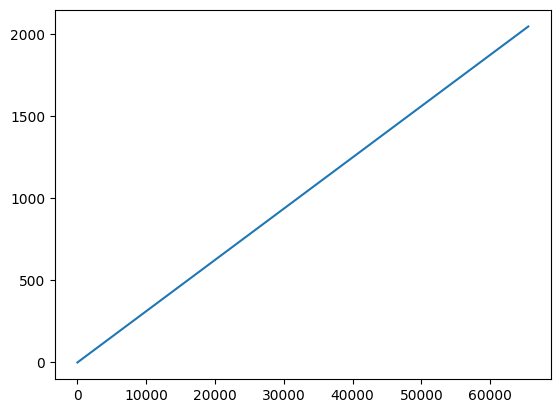

In [19]:
print(np.min(freqs))
print(np.max(freqs))
plt.plot()